

# Installation

  From pypi -
    https://airflow.apache.org/docs/apache-airflow/stable/installation/installing-from-pypi.html

    pip install "apache-airflow[celery]==2.2.2" --constraint "https://raw.githubusercontent.com/apache/airflow/constraints-2.2.2/constraints-3.6.txt"





# Intial setup

> airflow db init

> airflow users create -u admin -p admin -f joseph -l thomas -r Admin -e josephthomaa@gmail.com

> airflow webserver    => runs arirflow server

> airflow scheduler    => starts the scheduler

> airflow celery flower => for celery



# Usefull commands

> airflow dags list

> airflow tasks list < dagid >  // lists all tasks under a dag

> airflow dags trigger -e 2021-01-01 tutorial  // to trigger a dag

> airflow tasks test < dagid > < task > 2021-01-01 // to test a new task


> airflow config get-value core executor  // to see current executor



> pip install 'apache-airflow[postgres]' // install postgres for airflow, prerequisite - install postgresql

> pip install 'apache-airflow[celery]'


# Overview

* DAG: A DAG ( Directed Acyclic Graph ) is a finite directed graph that doesn’t have any cycles ( loops ). A DAG represents a collection of tasks to run, organized in a way that represent
their dependencies and relationships
* Operator: a class that acts as a template for carrying out some work
* Task: an instance of an operator
* Task Instance: a specific run of a task characterized as the combination of a dag, a task and a point 
in time.
>By combining DAGs and Operators to create TaskInstances, you can build complex workflows.

#Sample code


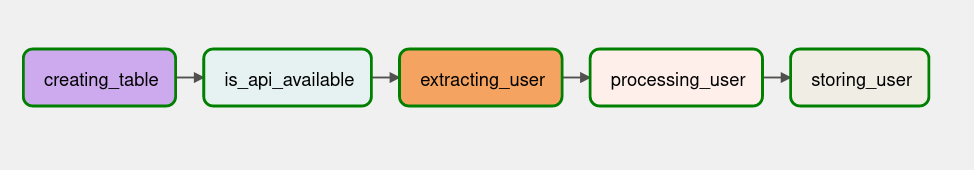

In [ ]:
from airflow.models import DAG
# importing different operators for tasks
from airflow.providers.sqlite.operators.sqlite import SqliteOperator
from airflow.providers.http.sensors.http import HttpSensor
from airflow.providers.http.operators.http import SimpleHttpOperator
from airflow.operators.python import PythonOperator
from airflow.operators.bash import BashOperator

from datetime import datetime
from pandas import json_normalize
import json

default_args = {
    'start_date': datetime(2021, 1, 1)
}

# method called during processing_user task
def _processing_user(ti):
    users = ti.xcom_pull(task_ids=['extracting_user'])
    if not len(users) or 'results' not in users[0]:
        raise ValueError("Data error")
    user = users[0]['results'][0]
    processed_user = json_normalize({
        'first_name': user['name']['first'],
        'lastname': user['name']['last'], 
        'country': user['location']['country'],
        'username': user['login']['username'], 
        'password': user['login']['password'],
        'email': user['email']  
    })
    processed_user.to_csv('/tmp/processed_user.csv', index=None, header=False)

# creating dag
with DAG('user_processing', schedule_interval='@daily', 
        default_args=default_args,
        catchup=False) as dag:

        # defining different tasks
        creating_table = SqliteOperator(
            task_id='creating_table',
            sqlite_conn_id='sqlite_default',
            sql='''
                CREATE TABLE IF NOT EXISTS users (
                    firstname TEXT NOT NULL,
                    lastname TEXT NOT NULL,
                    country TEXT NOT NULL,
                    username TEXT NOT NULL,
                    password TEXT NOT NULL,
                    email TEXT NOT NULL PRIMARY KEY
                );
            '''
        )

        is_api_available = HttpSensor(
                task_id="is_api_available",
                http_conn_id='user_api',
                endpoint='api/'
            )
        
        extracting_user = SimpleHttpOperator(
            task_id="extracting_user",
            http_conn_id='user_api',
            endpoint='api/',
            method='GET',
            response_filter=lambda respose: json.loads(respose.text),
            log_response=True
        )
        
        processing_user = PythonOperator(
            task_id='processing_user',
            python_callable=_processing_user
        )

        storing_user = BashOperator(
            task_id='storing_user',
            bash_command='echo -e ".separator ","\n.import /tmp/processed_user.csv users" | sqlite3 /tmp/sqlite_default.db'
        )

        # order which task is called
        creating_table >> is_api_available >> extracting_user >> processing_user >> storing_user
